# Text ReID model demo

This notebook is a short showcase of Text ReID capabilies of a CLIP finetuned for the Text ReID task.

We will take various textual query and perform search on a short gallery of people.

In [1]:
from pathlib import Path

import torch
from torch.nn.functional import normalize
import matplotlib.pyplot as plt
from PIL import Image
from irra.datasets.build import build_dataloader
from irra.model.build import build_model
from irra.utils.checkpoint import Checkpointer
from irra.utils.iotools import load_train_configs
from irra.datasets.bases import tokenize

## Code and data loading

In [2]:
# Dataset and model loading
batch_size = 10
output_folder = Path.cwd() / "data" / "model"
args = load_train_configs( output_folder / "configs.yaml")
args.training = False
args.test_batch_size = batch_size
args.num_workers = 0
device = "cuda"

test_img_loader, test_txt_loader, num_classes = build_dataloader(args)
txt_dataset = test_txt_loader.dataset
model = build_model(args, num_classes=num_classes)
checkpointer = Checkpointer(model)
checkpointer.load(output_folder / "best.pth")
model = model.to(device)


Training Model with ['itc'] tasks
Resized position embedding from size:torch.Size([1, 197, 768]) to size: torch.Size([1, 193, 768]) with height:24 width: 8


In [3]:
# Extract preprocesed image
gallery = next(iter(test_img_loader))[1].cuda()

In [4]:
# Load images
img_size = (36 * 3, 96 * 3)
gallery_imgs = [
  Image.open(path).resize(img_size)
  for path in test_img_loader.dataset.img_paths[:10]
]

In [5]:
# Build tokenizer
def tokenize_caption(caption: str) -> torch.Tensor:
  return tokenize(caption, txt_dataset.tokenizer, txt_dataset.text_length, txt_dataset.truncate).unsqueeze(0)

tokenize_caption('hello').shape

torch.Size([1, 77])

## Search person

In [6]:
# Helper function
def display_gallery(gallery_imgs):
    plt.figure(figsize=(19, 4))
    for i, image in enumerate(gallery_imgs):
        plt.subplot(1, 10, i + 1)
        plt.imshow(image)
        plt.axis('off')
    plt.show()

def compute_similarities(tokens, gallery):
    with torch.no_grad():
        gallery_features_output, text_features_output = model.base_model(gallery, tokens)

    gallery_features = gallery_features_output[:, 0, :].float()
    query_features = text_features_output[torch.arange(text_features_output.shape[0]), tokens.argmax(dim=-1)].float()
    
    return torch.einsum('d,nd->n', normalize(query_features)[0], normalize(gallery_features)).cpu()

def perform_search(caption: str, gallery: torch.Tensor):
    tokens = tokenize_caption(caption).cuda()

    similarities = compute_similarities(tokens, gallery)
    ranks = torch.argsort(similarities, descending=True)
    
    plt.figure(figsize=(19, 4))
    for i_plot, rank in enumerate(ranks):
        plt.subplot(1, 10, i_plot + 1)
        plt.imshow(gallery_imgs[rank])
        plt.title(f"{similarities[rank]:6.2%}")
        plt.axis('off')
    plt.show()
    

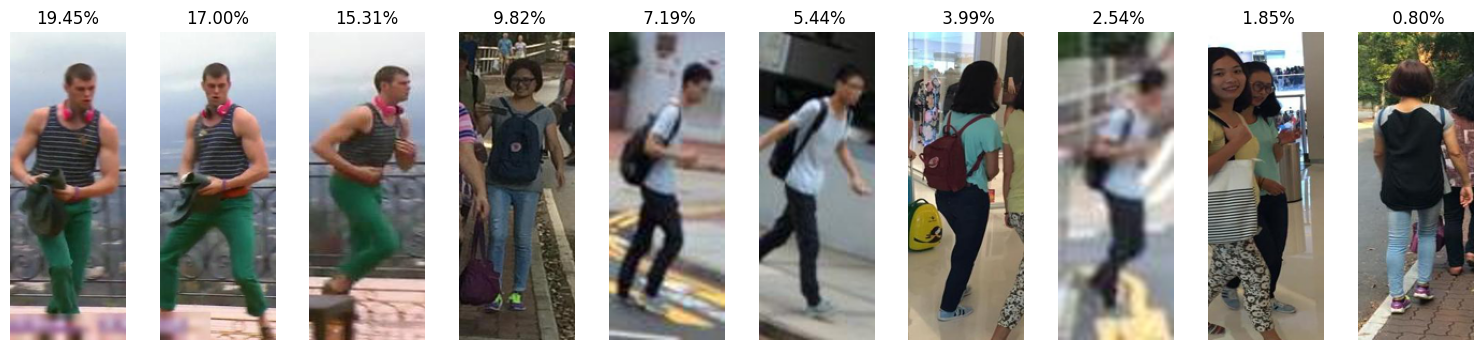

In [7]:
perform_search('a boy with a pink headset', gallery)

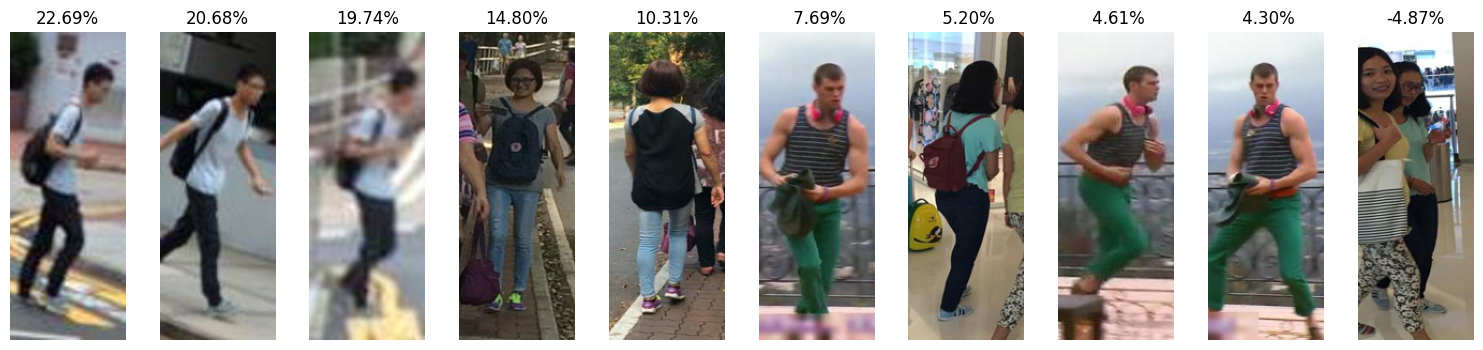

In [8]:
perform_search('a boy walking with a black backpack', gallery)

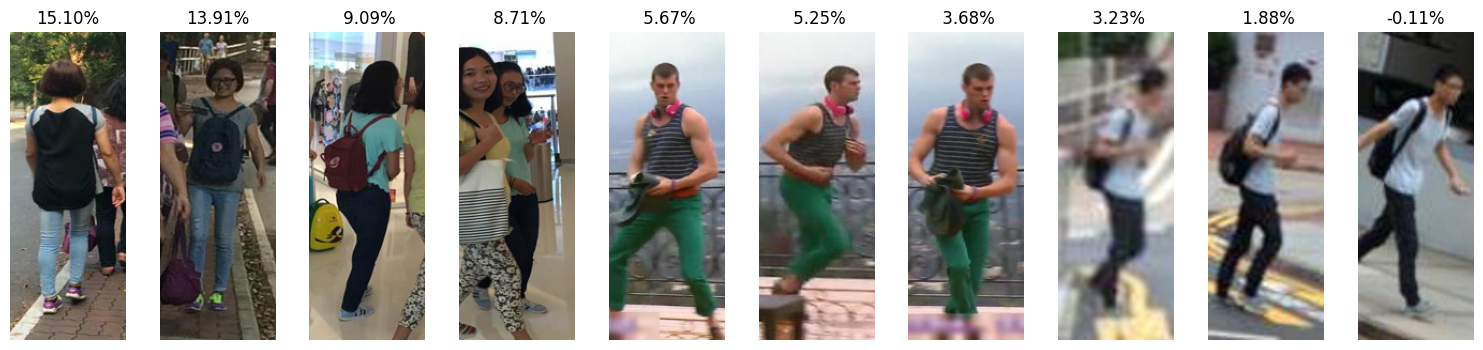

In [9]:
perform_search('a woman with a square haircut', gallery)